In [1]:
import findspark
findspark.init()

import wptools
import pyspark
import pyspark.sql
from pyspark.sql import *
import os.path
from pyspark.sql.functions import desc

from pyspark.sql import dataframe
from pyspark.sql import functions as F

from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import SQLContext

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [61]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import hashlib

%matplotlib inline

# import get_ref_info.py
import os
import sys
my_fun = './utils/'
if my_fun not in sys.path:
    sys.path.append(my_fun)
    
from get_ref_info import *
from operator import add

try:
    from urllib.parse import urlparse
except ImportError:
     from urlparse import urlparse

import seaborn as sns
import numpy as np
from pyspark.sql.functions import regexp_replace, col

import time
from datetime import timedelta, date
from mwviews.api import PageviewsClient
from collections import OrderedDict
DATA_DIR = './data/data_processed/' 

sc.addPyFile("./utils/get_ref_info.py")

# Loading data 

**File schema** is shown.

In [3]:
WIKIPEDIA_CONFLICTS_PARQUET = DATA_DIR + 'selectedAllConflict.parquet'

# loading the saved parquet files
wikipedia_ = spark.read.parquet(WIKIPEDIA_CONFLICTS_PARQUET)
# show file schema
wikipedia_.printSchema()

root
 |-- id: long (nullable = true)
 |-- ns: long (nullable = true)
 |-- restrictions: string (nullable = true)
 |-- revision: struct (nullable = true)
 |    |-- comment: struct (nullable = true)
 |    |    |-- _VALUE: string (nullable = true)
 |    |    |-- _deleted: string (nullable = true)
 |    |-- contributor: struct (nullable = true)
 |    |    |-- _VALUE: string (nullable = true)
 |    |    |-- _deleted: string (nullable = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- ip: string (nullable = true)
 |    |    |-- username: string (nullable = true)
 |    |-- format: string (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- minor: string (nullable = true)
 |    |-- model: string (nullable = true)
 |    |-- parentid: long (nullable = true)
 |    |-- sha1: string (nullable = true)
 |    |-- text: struct (nullable = true)
 |    |    |-- _VALUE: string (nullable = true)
 |    |    |-- _xml:space: string (nullable = true)
 |    |-- timestamp: string (nulla

In [4]:
# how many articles are there?
print("Number of articles: {}".format(wikipedia_.count()))

Number of articles: 18782


---

# Article outliers removal

We have some outliers we need to deal with, as a first step we use keywords (**"war, riot, conflict, protest, revolt, operation, attack, annexation, genocide, insurgency, crisis, confrontation, clash"**) on the article titles to extract from our chosen categories (`civilian attack`, `civil conflict`, `military conflict`).

For example, we found that some articles in `civilian attack` may contain the infobox `civilian attack` but are not really a `civilian attack`. The following page 

> Fraunces Tavern: Fraunces Tavern is a landmark museum and restaurant in New York City, situated at 54 Pearl Street at the corner of Broad Street. The location played a prominent role in history before, during and after the American Revolution, serving as a headquarters for George Washington, a venue for peace negotiations with the British, and housing federal offices in the Early Republic.

Since some pages are considered **outliers**, we remove them using the method described above and remove any disambiguations.

In [5]:
# filter out outliers
outlier_regex = "war*|battle*|siege*|campaign*|riot*|conflict*|protest*|revolt*|operation*|attack*|annexation*|genocide*|insurgency*|crisis*|confrontation*|clash*"
wikipedia = wikipedia_.filter(~F.lower(wikipedia_['title']).rlike(outlier_regex))
print("Number of articles without outliers: {}".format(wikipedia.count()))

wikipedia = wikipedia.filter("lower(revision.text._VALUE) not like '%{disambiguation}%'")
# save in parquet
wikipedia.write.parquet(DATA_DIR+"wikipedia_no_outliers.parquet")
# load from parquet so that the rest of notebook uses cleaned version of data
wikipedia = spark.read.parquet(DATA_DIR+"wikipedia_no_outliers.parquet")

#problema dei filters: già mancano battle, campaign, siege, ... In più ci sono cose tipo https://en.wikipedia.org/wiki/Falaise_Pocket che dovrebbero rimanere incluse

Number of articles without outliers: 5651


Alternativa per gli outliers ditemi cosa ne pensate

In [5]:
wikipedia = spark.read.parquet(WIKIPEDIA_CONFLICTS_PARQUET)

In [6]:
regex = r"([A-z].+?(?=,)|[A-z].*?$)"
cat_regex = re.compile(regex,re.IGNORECASE);

In [7]:
categories = [];
def extr_categories(text):
    global categories
    categories = categories + cat_regex.findall(text);

In [8]:
categories = [];
for i in wikipedia.select(F.lower(col('categories')).alias('categories')).collect(): #lcase
    extr_categories(i[0])

In [9]:
categories_unique = list(set(categories))
categories_map = map(str.strip, [str(i) for i in categories_unique])
print(list(categories_map))

['mountain range', 'protected area', 'milit', 'islands', 'historical event', 'newspaper', 'east asian', 'building', 'event', 'monarch', 'united states district court case', 'korean name', 'historic building', 'aircraft incident', 'television', 'nrhp', 'australian place', 'book', 'military conflict', 'civilian attack', 'airport', 'ship begin', 'protected area', 'military person', 'monument', 'news event', 'murderer', 'pahistoric', 'airliner accident', 'legislature', 'operational plan', 'court case', 'subbox = yes', 'service record', 'person', 'aircraft occurrence', 'military conflict  <', 'legislation', 'former country', 'military person', 'ship image', 'treaty', 'military structure', 'mass murderer', 'law enforcement agency', 'nrhp', 'holiday', 'shopping mall', 'film', 'ship career', 'former subdivision', 'uk feature', 'greek dimos', 'football match', 'military operation', 'historic site', 'person', 'national military', 'east asian name', 'election', 'ship characteristics', 'school', '

In [16]:
mainCategories = ['civil conflict','military conflict','civilian attack']

filteredCategoryMap=[]
for i in categories_map:
    if not any(s in i for s in mainCategories):
        if i == 'milit': #Battle of Tolbiac give a problem because of a umlaut
            continue
        filteredCategoryMap+=[i];

filteredCategoryMap = list(set(filteredCategoryMap))
#create a dynamic regex
forReg = '|'.join(filteredCategoryMap);

In [11]:
wikiExtraCat = wikipedia.filter(F.lower(wikipedia.categories).rlike(forReg))
wikiExtraCat.count()

18782

questo vuole dire che ci sono **345** articoli che hanno **anche altre categorie**, non sono molti volendo potremmo scartarli già tutti

In [12]:
outliers_categories = ['police officer','person','tv channel','historic building',
                       'service record','ship career','news event','legislature'
                       'national military','islands','shopping mall',
                       'museum','legislation','referendum',
                       'nobility','serial killer','officeholder','decat = yes',
                       'television','newspaper','former subdivision','film',
                       'book','bilateral relations','monarch','building','organization']

wikipedia.select("id","title","categories", "revision").filter(F.lower(wikipedia.categories).rlike('|'.join(outliers_categories))).count()

109

e alla fine scartiamo solo 109 articoli... boh non saprei, secondo me ci siamo dai

In [13]:
wikipedia = wikipedia.select("id","title","categories","revision").filter(~F.lower(wikipedia.categories).rlike('|'.join(outliers_categories)))
wikipedia.count()

18673

In [14]:
wikipedia.printSchema()

root
 |-- id: long (nullable = true)
 |-- title: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- revision: struct (nullable = true)
 |    |-- comment: struct (nullable = true)
 |    |    |-- _VALUE: string (nullable = true)
 |    |    |-- _deleted: string (nullable = true)
 |    |-- contributor: struct (nullable = true)
 |    |    |-- _VALUE: string (nullable = true)
 |    |    |-- _deleted: string (nullable = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- ip: string (nullable = true)
 |    |    |-- username: string (nullable = true)
 |    |-- format: string (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- minor: string (nullable = true)
 |    |-- model: string (nullable = true)
 |    |-- parentid: long (nullable = true)
 |    |-- sha1: string (nullable = true)
 |    |-- text: struct (nullable = true)
 |    |    |-- _VALUE: string (nullable = true)
 |    |    |-- _xml:space: string (nullable = true)
 |    |-- timestamp: string (nu

In [15]:
# save to binary files 
wikipedia.write.mode('overwrite').parquet("data/data_processed/wikipedia_no_outliers.parquet");

We explore how many articles have each **keyword** selected in the given keywords. 

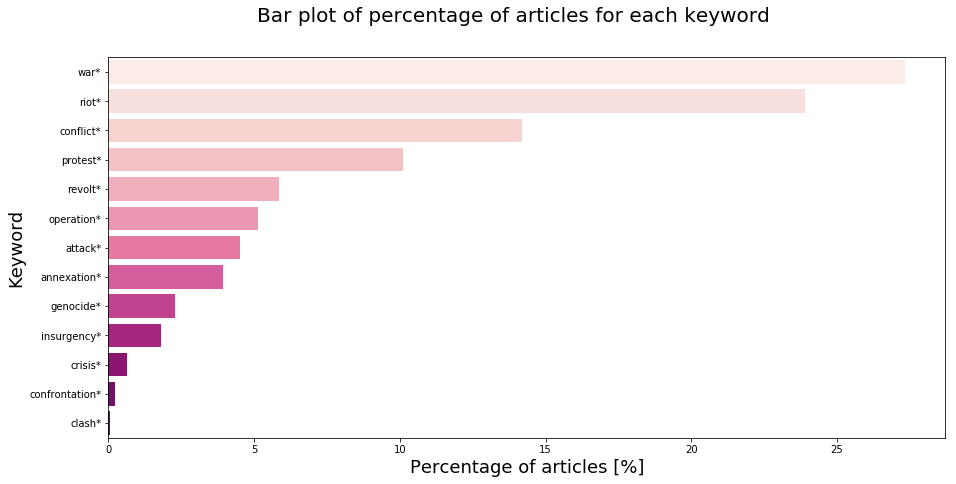

In [51]:
keyword_wikipedia = spark.read.parquet(DATA_DIR+"wikipedia_no_outliers.parquet")

titles = outlier_regex.split('|')

titles_count = pd.DataFrame(np.zeros((len(titles), )), index=titles, columns=['count'])
# computationally less expansive
wiki_titles = keyword_wikipedia.select('title')

# count the titles that contains titles
for ele in titles:
    titles_count.loc[ele] = wiki_titles.filter(wiki_titles.title.rlike(ele)).count()

    
titles_count['count'] = titles_count['count']*100/titles_count['count'].sum()  
f, ax1 = plt.subplots()
plt.sca(ax1)
sns.barplot(
    x='count', y=titles_count.index, data=titles_count.sort_values('count', ascending=False), 
    orient='h', palette="RdPu"
);

plt.xlabel('Percentage of articles [%]',fontsize=18)
plt.ylabel('Keyword',fontsize=18)
f.suptitle('Bar plot of percentage of articles for each keyword', fontsize=20)
f.set_size_inches(15, 7)
plt.show()

**Bar plot of percentage of articles for each keyword.** 

We can see that the keyword `war, riot` together make up for ~50% of the articles. Very little articles are associated to `clash` or `confrontation`.

---
# Quantifying *importance* of each page in each category

We want to see how *important* each page is in each category. As we are solely focusing on *'war'*-related subjects in this pilot phase, we define *page importance* by the number of deaths. 

## Infobox or Wikidata per category 

Functions `get_wiki_civilian_attack`, `get_wiki_military_conflict`
to get relevant information and views for each category: `civilian attack`, `military conflict`. 
Data is obtained either using the page's wikidata is the data exists or acquired through infobox parsing.
Relevant information is chosen based on the fields found on [List of infoboxes and fields](https://en.wikipedia.org/wiki/Wikipedia:List_of_infoboxes#Event) 

Extract info for each category in **Infobox**:
* `civilian attack`
    * location
    * date 
    * fatalities
* `military conflict`
    * place
    * date 
    * casualities1
* `civil conflict`
    * place
    * date 
    * casualities1
    
Extract info for each category in **Wikidata**:
* `civilian attack`
    * location
    * date 
    * fatalities
* `military conflict`
    * 'number of deaths (P1120)']['amount']
    * 'end time (P582)'
    * 'location (P276)'
* `civil conflict`
    * 'number of deaths (P1120)']['amount']
    * 'end time (P582)'
    * 'location (P276)'
    
We use an external library [wptools wiki](https://github.com/siznax/wptools/wiki) to help us parse the data. 

### Categories
We focus on categories : `civilian attack`, `military conflict`, `civil conflict` from our pre-filtered wikipedia dump data which had 3 categories: `civilian attack`, `military conflict`, `civil conflict` (key words we used via regex expression to extract articles containing infoboxes with such headers by parsing the revision.text.__VALUE). 

We also found a list of all ongoing civil wars listed on [wikipedia](https://en.wikipedia.org/wiki/List_of_civil_wars#Ongoing_civil_wars) have a `Template:Infobox military`. This may be of interest in a later step.

[List of ongoing civil wars](https://en.wikipedia.org/wiki/List_of_civil_wars#Ongoing_civil_wars):
 * Myanmar, Internal conflict in Myanmar, since 1948
 * Indonesia, Papua conflict, since 1962
 * Colombia, Colombian conflict, since 1964
 * Afghanistan, War in Afghanistan, since 1978
 * Turkey, Kurdish–Turkish conflict since 1978
 * Somalia, Somali Civil War, since 1988
 * Sudan, three conflicts
* War in Darfur, since 26 February 2003
* Sudanese nomadic conflicts, since 26 May 2009 through at least 2017
* Sudanese conflict in South Kordofan and Blue Nile since 5 June 2011
 * Pakistan, War in North-West Pakistan, since 16 March 2004
 * Paraguay, Paraguayan People's Army insurgency, since 2005
 * Syria, Syrian Civil War, since 15 March 2011, also see List of armed groups in the Syrian Civil War
 * Central African Republic, Central African Republic conflict, since 10 December 2012
 * South Sudan, South Sudanese Civil War, since 15 December 2013
 * Libya, Second Libyan Civil War, since 16 May 2014
 * Yemen, Second Yemeni Civil War, since 19 March 2015

In [4]:
def get_wiki_military_conflict(entity):
    page = wptools.page(pageid=entity.id)
    # extract relevant information and put in dictionary
    info = {'death': None, 'end_date': None, 'location': None}
    try:
        page.get_parse()
    except:
        return Row(id=entity.id, death=info['death'],
               end_date=info['end_date'], location=info['location'])
    
    try: 
        page.get_wikidata()
        info['death'] = page.data['wikidata']['number of deaths (P1120)']['amount']
    
    except:
        try:
            info['death'] = page.data['infobox']['casualties1']
        except:
            info['death'] = None
            
    try:
        info['end_date'] = page.data['wikidata']['end time (P582)']
    except:
        try:
            info['end_date'] = page.data['infobox']['date']
        except:
            info['end_date'] = None
    
    try:
        info['location'] = page.data['wikidata']['location (P276)']
    except:
        try:
            info['location'] = page.data['infobox']['place']
        except:
            info['location'] = None
    
    
    return Row(id=entity.id, death=info['death'],
               end_date=info['end_date'], location=info['location'])

def get_wiki_civilian_attack(entity):
    page = wptools.page(pageid=entity.id)
    # extract relevant information and put in dictionary
    info = {'death': None, 'end_date': None, 'location': None}
    try:
        page.get_parse()
    except:
        return Row(id=entity.id, death=info['death'],
               end_date=info['end_date'], location=info['location'])
    
    try: 
        page.get_wikidata()
        info['death'] = page.data['wikidata']['number of deaths (P1120)']['amount']
    
    except:
        try:
            info['death'] = page.data['infobox']['fatalities']
        except:
            info['death'] = None
            
    try:
        info['end_date'] = page.data['wikidata']['end time (P582)']
    except:
        try:
            info['end_date'] = page.data['infobox']['date']
        except:
            info['end_date'] = None
    
    try:
        info['location'] = page.data['wikidata']['location (P276)']
    except:
        try:
            info['location'] = page.data['infobox']['location']
        except:
            info['location'] = None
    
    
    return Row(id=entity.id, death=info['death'],
               end_date=info['end_date'], location=info['location'])

In [3]:
from pyspark.sql.types import *

### Wikidata & Infobox `military conflict `

In [117]:
infobox_military_conflict = 'military conflict'
# find all pages that have category military conflict
wiki_military_conflict = wikipedia.where("categories like '%{}%'".format(infobox_military_conflict)) 

In [119]:
df = wiki_military_conflict.select("id");
df.count()

14158

In [7]:
%%capture
wiki_military_conflict_rows = [get_wiki_military_conflict(i) for i in df.collect()];

In [9]:
schema = StructType([StructField('death', StringType()),StructField('end_date', StringType()),
                     StructField('id', IntegerType()),StructField('location', StringType())])

In [10]:
wiki_military_attack_df = spark.createDataFrame(wiki_military_conflict_rows, schema)

wiki_military_attack_df.printSchema()
wiki_military_attack_df.show()

root
 |-- death: string (nullable = true)
 |-- end_date: string (nullable = true)
 |-- id: integer (nullable = true)
 |-- location: string (nullable = true)

+--------------------+--------------------+------+--------------------+
|               death|            end_date|    id|            location|
+--------------------+--------------------+------+--------------------+
|Some injuries, no...|    August 1–2, 1946|655845|   Athens (Q3292481)|
|{{ubl|1 light cru...|{{start date|1940...|656035|    Calabria (Q1458)|
|1,432 killed in c...|+1912-10-18T00:00...|656087|Vilayet of Tripol...|
|approx. 1,000 killed|+1919-08-08T00:00...|656173|[[North-West Fron...|
|Total fatalities ...|+1880-00-00T00:00...|656175|[Emirate of Afgha...|
|                null|July 1778 – Febru...|656473|Illinois Country ...|
|250–300 casualtie...|    2–5 October 1939|659156|      Kock (Q991819)|
|         '''1,900'''|{{Start date|1864...|659506|Fulton County (Q4...|
|                null|1961–1990 (29 years)|661656|

In [11]:
# saving binary file to future uses
wiki_military_attack_df.write.mode('overwrite').parquet("data/data_processed/wiki_military_conflict_df.parquet");

### Wikidata & Infobox `civilian attack`

In [130]:
infobox_civilian_attack = 'civilian attack'
# find all pages that have category civilian attack
wiki_civilian_attack = wikipedia.where("categories like '%{}%'".format(infobox_civilian_attack));

In [132]:
df = wiki_civilian_attack.select("id");
df.count()

2468

In [133]:
%%capture
wiki_civilian_attack_rows = [get_wiki_civilian_attack(i) for i in df.collect()];

In [5]:
schema = StructType([StructField('id', IntegerType()),
                     StructField('death', StringType()),StructField('end_date', StringType()),
                     StructField('location', StringType())])

In [134]:
wiki_civilian_attack_df = spark.createDataFrame(wiki_civilian_attack_rows, schema)

wiki_civilian_attack_df.printSchema()
wiki_civilian_attack_df.show()

root
 |-- id: integer (nullable = true)
 |-- death: string (nullable = true)
 |-- end_date: string (nullable = true)
 |-- location: string (nullable = true)

+-------+--------------------+--------------------+--------------------+
|     id|               death|            end_date|            location|
+-------+--------------------+--------------------+--------------------+
| 676659|   500,000–1,000,000|7 April {{spaced ...|          [[Rwanda]]|
| 683450|[[Patrick Argüell...|6– {{end date|df|...|     Zarqa (Q148062)|
|1611176|        Up to 30,000|          April 1909|Adana Vilayet (Q1...|
|1611202|     200,000–400,000|           1894–1896|Ottoman Empire (Q...|
|1634876|10 (including the...|                null| Red Lake (Q1012803)|
|1655234|                  +7|          1 May 2004|     Yanbu (Q466027)|
|3119912|                  +1|    November 8, 2005|Jacksboro (Q2738438)|
|3137442|Barbara Richardso...|{{start date|1981...|8763 Wonderland A...|
|3177125|:16 (at least) 
*...|: August 

In [135]:
wiki_civilian_attack_df.count()

2468

In [136]:
# saving binary file to future uses
wiki_civilian_attack_df.write.mode('overwrite').parquet("wiki_civilian_attack_df.parquet");

### Wikidata & Infobox `civil conflict`

In [137]:
infobox_civil_conflict = 'civil conflict'
# find all pages that have category civilian attack
wiki_civil_conflict = wikipedia.where("categories like '%{}%'".format(infobox_civil_conflict)) 

In [140]:
df = wiki_civil_conflict.select("id");
df.count()

847

In [141]:
%%capture
wiki_civil_conflict_rows = [get_wiki_military_conflict(i) for i in df.collect()];

In [142]:
wiki_civil_conflict_df = spark.createDataFrame(wiki_civil_conflict_rows, schema)

wiki_civil_conflict_df.printSchema()
wiki_civil_conflict_df.show()

root
 |-- id: integer (nullable = true)
 |-- death: string (nullable = true)
 |-- end_date: string (nullable = true)
 |-- location: string (nullable = true)

+-------+--------------------+--------------------+--------------------+
|     id|               death|            end_date|            location|
+-------+--------------------+--------------------+--------------------+
| 661864|                null|11, 12 and 13 Sep...|[[Melbourne]], [[...|
| 664490|'''Deaths''': 3<b...|  January–March 1912|[[Lawrence, Massa...|
|1613199|                null|May 28 and July 2...|[[East St. Louis,...|
|1619134|                null|February 24, 2005...|  [[Quebec]], Canada|
|3138671|'''Shootout''':<b...|July 23–24, 1968 ...|[[Glenville, Clev...|
|3158301|                null|            May 1971|[[Washington, D.C...|
|1113889|                  +2|  August 19–21, 1991|[[Crown Heights, ...|
| 152287|{{plainlist|
*14 ...|[+1878-07-19T00:0...|[[Lincoln County,...|
|  43573|                null|      Apr

In [143]:
wiki_civil_conflict_df.count()

847

In [144]:
# saving binary file to future uses
wiki_civil_conflict_df.write.mode('overwrite').parquet("wiki_civil_conflict_df.parquet");

---

# Popularity Metrics

## Loading the data

In [18]:
# Loading the data
WIKIPEDIA_REFERENCES_PARQUET = DATA_DIR + "wikipedia_no_outliers.parquet"

# loading the saved parquet files
wikipedia_ref = spark.read.parquet(WIKIPEDIA_REFERENCES_PARQUET)
wikipedia_ref.show(10)

+------+--------------------+-----------------+--------------------+
|    id|               title|       categories|            revision|
+------+--------------------+-----------------+--------------------+
|655845|Battle of Athens ...|military conflict|[, [,, 5175837,, ...|
|656035|  Battle of Calabria|military conflict|[[link,], [,, 268...|
|656087|   Italo-Turkish War|military conflict|[, [,,, 96.77.37....|
|656173|Third Anglo-Afgha...|military conflict|[[Formatting.,], ...|
|656175|Second Anglo-Afgh...|military conflict|[[/* 1879 */The B...|
|656473|   Illinois campaign|military conflict|[[Moved images.,]...|
|659156|Battle of Kock (1...|military conflict|[, [,, 29980587,,...|
|659506|Battle of Peachtr...|military conflict|[[c/e.,], [,, 193...|
|661656|Nicaraguan Revolu...|military conflict|[, [,, 33124044,,...|
|661864|       S11 (protest)|   civil conflict|[[Rescuing 3 sour...|
+------+--------------------+-----------------+--------------------+
only showing top 10 rows



## POPULARITY METRIC 1

### Get number of references per page

We use our pre-filtered data and we count the number of tag of type ```<ref>```, by parsing all pages to get the number of references. We think that the more *popular* a page is, the more references it will contain.

We want to see:
* how many references a page has
* what does the distribution of the references look like 
* what are the top domains across these articles 
* how many articles have a reference to each domain

The analysis is based on work from *Research:Characterizing Wikipedia Citation Usage*: [MetaPageQueries](https://meta.wikimedia.org/wiki/Research:Characterizing_Wikipedia_Citation_Usage/First_Round_of_Analysis#Dimensions_of_Analysis)

Example of reference format:
```html
<ref>{{cite web| url=http://geonames.nga.mil/ggmagaz/geonames4.asp 
    |title=NGA GeoName Database |publisher=[[National Geospatial Intelligence Agency]] 
    |accessdate=2008-07-05 
    |archiveurl = https://web.archive.org/web/20080608190852/http://geonames.nga.mil/ggmagaz/geonames4.asp 
    <!-- Bot retrieved archive --> |archivedate = 2008-06-08}}</ref>
```

**quantify the number of references per page**
    * using regex expression to find the references in the page
    * counting the number of references

In [19]:
# quantify the number of references per page

# Compile a regular expression pattern into a regular expression object, 
#which can be used for matching using its findall.
just_ref_regex = re.compile(r'<ref[^>]*[^\/]>|<ref[ ]*>')

# find # references <ref> per page 
def get_refs_count(entity, regex_expression=just_ref_regex ):
    # get access to value in text in revision
    text = entity.revision.text._VALUE
    # find references
    refs = just_ref_regex.findall(text)
    return Row(id=entity.id, refs_count=len(refs), categories=entity.categories)

In [20]:
# get the # of references per page
# Creates a DataFrame from an RDD, apply counting function with regex expression
reference_count_page = sqlContext.createDataFrame(wikipedia_ref.rdd.map(get_refs_count))
reference_count_page.sort('refs_count', ascending=False).show(5)
reference_count_page_sql = reference_count_page.registerTempTable('reference_count_page_sql')

+-----------------+--------+----------+
|       categories|      id|refs_count|
+-----------------+--------+----------+
|military conflict|52019122|      1000|
|military conflict|46230181|       818|
|military conflict|42563745|       734|
|military conflict|43243199|       609|
|military conflict|     771|       598|
+-----------------+--------+----------+
only showing top 5 rows



In [21]:
# quantify the # articles with # ref > 0: 
non_zero_ref_query = """
select count(DISTINCT id)
from reference_count_page_sql
where refs_count > 0
"""
non_zero_articles = spark.sql(non_zero_ref_query)

non_zero_articles_pd = non_zero_articles.toPandas().iloc[0,0]
print("Number of articles with #references > 0: " + str(non_zero_articles_pd))

Number of articles with #references > 0: 15879


**Distribution of number of references** We bin the number of references to get the number of pages having at least x #references. This is observed with a histogram plot.

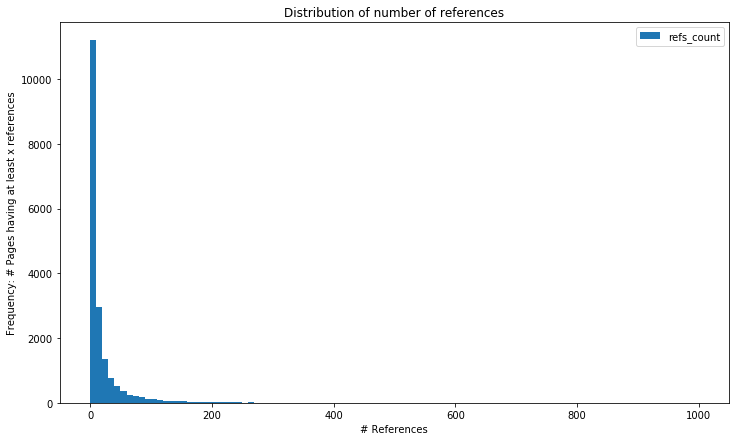

In [22]:
just_refs_count = reference_count_page.select('refs_count').toPandas()
just_refs_count.plot(kind="hist", bins=100, 
                     figsize=(12,7), title="Distribution of number of references")
plt.xlabel('# References')
plt.ylabel('Frequency: # Pages having at least x references')
plt.show()

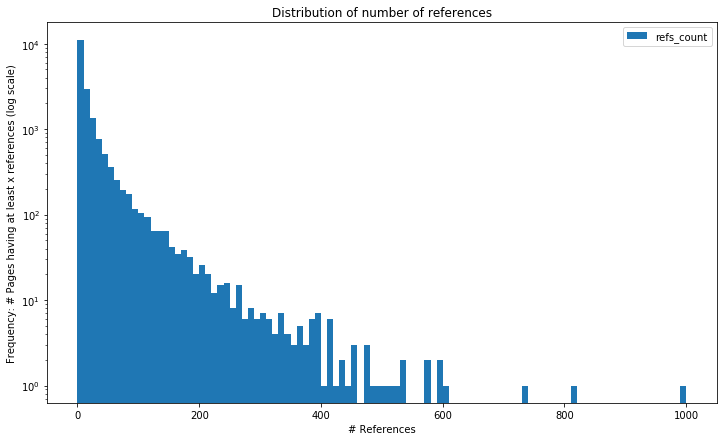

In [23]:
just_refs_count = reference_count_page.select('refs_count').toPandas()
just_refs_count.plot(kind="hist", bins=100, log = True,
                     figsize=(12,7), title="Distribution of number of references")
plt.xlabel('# References')
plt.ylabel('Frequency: # Pages having at least x references (log scale)')
plt.show()

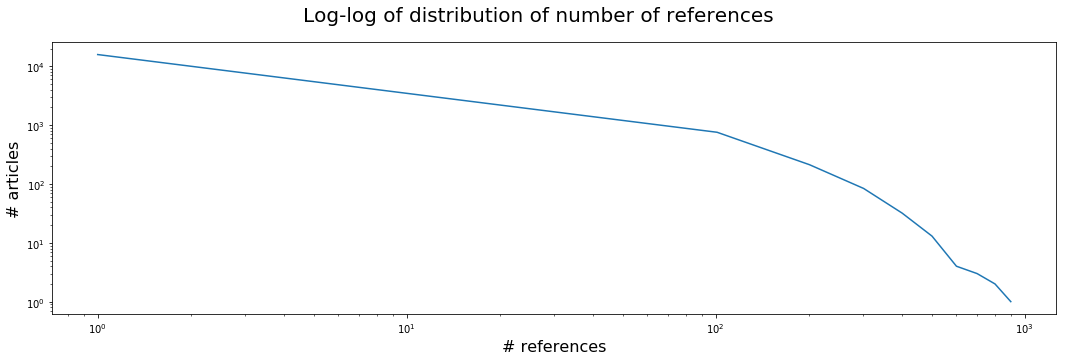

In [24]:
step = 100;
xs = pd.Series(range(1,int(just_refs_count.max()),step));
gratherThanData = xs.apply(lambda x: (just_refs_count.refs_count[just_refs_count.refs_count>=x]).count());

f, (ax2) = plt.subplots(1, 1);
plt.sca(ax2);
plt.plot(xs,gratherThanData);
plt.xlabel('# references',fontsize=16);
plt.ylabel('# articles',fontsize=16);
plt.yscale('log'); plt.xscale('log');
f.set_size_inches(18, 5)
f.suptitle('Log-log of distribution of number of references',fontsize=20)
plt.show();

**Distribution of number of references**: It seems that the distribution may follow a power law. To verify our suspicions, we plot our cumulative distribution in normal axes and in log-log axes. We look at a "cumulative distribution": how many references have at least x pages?

The distribution has a heavy-tailed distribution: it may follow a power law. To recognize if the distirbutions follow a power law, we plot the data in log-log axes. If it follows a power law, reporting mean or variance for a power-law-distributed data is not relevant as these statistics are not robust as they are sensitive to data. Instead, we use robust statistics and report the median and quartiles using boxplots. We compare boxplots with and without outliers.

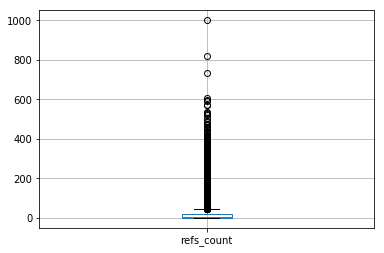

In [25]:
# with all data
just_refs_count.boxplot();

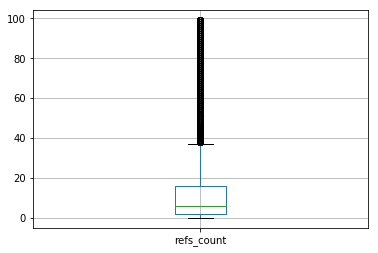

In [26]:
# without extreme values (discard outliers)
just_refs_count[just_refs_count['refs_count']< 100].boxplot();

### Get the domains of references

In [35]:
references_rrd = wikipedia_ref.rdd.flatMap(get_ref_info)
references = sqlContext.createDataFrame(references_rrd)
references.show(5)

+------+---------+--------------------+--------------------+
|    id| template|               title|                 url|
+------+---------+--------------------+--------------------+
|655845|cite book|     South vs. South|                    |
|655845|cite book|       McMinn County|https://archive.o...|
|655845|cite book|     South vs. South|                    |
|655845|cite book|       McMinn County|https://archive.o...|
|655845| cite web|The Battle of Athens|http://www.americ...|
+------+---------+--------------------+--------------------+
only showing top 5 rows



**URL parsing** 
Parse a URL into six components, returning a 6-tuple. This corresponds to the general structure of a URL: scheme://netloc/path;parameters?query#fragment. Each tuple item is a string, possibly empty.

In [38]:
def get_domain(row):
    # parse url and return for each row (url, 1) where 1 is the occurence of ref = 1 for that page
    try:
        parsed_uri = urlparse(row['url'])
        return ('{uri.netloc}'.format(uri=parsed_uri), 1)
    except:
        return None

mapped_domains = references.where("length(url)>0").rdd.map(get_domain).filter(lambda row: row is not None)
# for each domain count how many references there are in total to find top domains
domains_count = mapped_domains.reduceByKey(lambda a,b: a+b).filter(lambda r: len(r[0])>0).sortBy(lambda r: -r[1])
domains_count.take(30)

[('books.google.com', 10113),
 ('www.nytimes.com', 4170),
 ('www.reuters.com', 3715),
 ('www.almasdarnews.com', 3397),
 ('www.theguardian.com', 3313),
 ('www.bbc.co.uk', 2829),
 ('news.bbc.co.uk', 2318),
 ('www.aljazeera.com', 1988),
 ('www.washingtonpost.com', 1970),
 ('www.bbc.com', 1962),
 ('www.cnn.com', 1541),
 ('www.syriahr.com', 1518),
 ('www.telegraph.co.uk', 1505),
 ('edition.cnn.com', 1170),
 ('www.independent.co.uk', 976),
 ('abcnews.go.com', 840),
 ('twitter.com', 811),
 ('www.haaretz.com', 707),
 ('www.foxnews.com', 689),
 ('www.dailystar.com.lb', 682),
 ('www.dawn.com', 678),
 ('www.jpost.com', 677),
 ('www.wsj.com', 626),
 ('www.youtube.com', 619),
 ('news.yahoo.com', 614),
 ('www.cbsnews.com', 607),
 ('archive.org', 605),
 ('www.huffingtonpost.com', 580),
 ('www.latimes.com', 577),
 ('www.dailymail.co.uk', 565)]

In [39]:
# count the number of links
number_links = domains_count.map(lambda r: r[1]).reduce(add)
print("Total number of links: {}".format(number_links))

Total number of links: 163487


In [40]:
def percentage(rdd):
    return Row(domain=rdd[0], count=rdd[1], perc=rdd[1]*100/number_links)

domains_distribution = sqlContext.createDataFrame(domains_count.map(percentage)).sort("count", ascending=False)
domains_distribution.show()

+-----+--------------------+-------------------+
|count|              domain|               perc|
+-----+--------------------+-------------------+
|10113|    books.google.com|  6.185812939255109|
| 4170|     www.nytimes.com| 2.5506615204878673|
| 3715|     www.reuters.com| 2.2723519301228845|
| 3397|www.almasdarnews.com|  2.077841051582083|
| 3313| www.theguardian.com| 2.0264608195147016|
| 2829|       www.bbc.co.uk| 1.7304128156978842|
| 2318|      news.bbc.co.uk| 1.4178497372879801|
| 1988|   www.aljazeera.com| 1.2159988255946956|
| 1970|www.washingtonpos...|  1.204988775865971|
| 1962|         www.bbc.com| 1.2000954204309824|
| 1541|         www.cnn.com| 0.9425825906647012|
| 1518|     www.syriahr.com| 0.9285141937891086|
| 1505| www.telegraph.co.uk|  0.920562491207252|
| 1170|     edition.cnn.com| 0.7156532323670995|
|  976|www.independent.c...| 0.5969893630686232|
|  840|      abcnews.go.com|  0.513802320673815|
|  811|         twitter.com|0.49606390722198096|
|  707|     www.haar

In [41]:
domains_distribution_pd = domains_distribution.toPandas().set_index('domain')

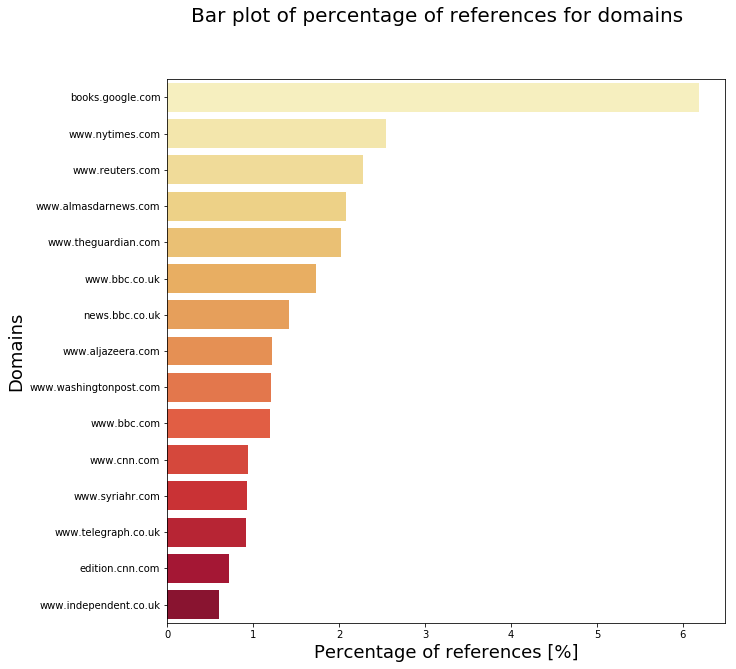

In [42]:
domains_distribution_pd20 = domains_distribution_pd.head(15)

# plot using bar plot
f, ax1 = plt.subplots()
plt.sca(ax1)
sns.barplot(domains_distribution_pd20['perc'], domains_distribution_pd20.index, palette="YlOrRd", ax=ax1, orient='h')
plt.xlabel('Percentage of references [%]',fontsize=18)
plt.ylabel('Domains',fontsize=18)
f.suptitle('Bar plot of percentage of references for domains', fontsize=20)
f.set_size_inches(10, 10)
plt.show()

# Popularity metric 2

### Get number of views per page

A way of measuring the popularity of a page can be done by looking at the number of views per page. Let's follow the trend!

In [45]:
# Loading the data
WIKIPEDIA_VIEWCOUNT_PARQUET = DATA_DIR + "wikipedia_no_outliers.parquet"
# loading the saved parquet files
wikipedia_VIEWS = spark.read.parquet(WIKIPEDIA_VIEWCOUNT_PARQUET)

In [46]:
df = wikipedia_VIEWS.select("title")
conflict_array = [(i.title) for i in df.collect()];

In [47]:
def getViewsFromAPI(conflict_array):
    views_dict = p.article_views('en.wikipedia', conflict_array, granularity='monthly',
                                 start='20150701', end=time.strftime('%Y%m%d'), agent='user')
    return views_dict

In [48]:
startingLogDate = '20150701';
today = time.strftime('%Y%m%d');

p = PageviewsClient(user_agent="<ada@epfl.ch> Applied data analysis project")

views_dict = p.article_views('en.wikipedia', conflict_array, granularity='monthly', start=startingLogDate, end=today, agent='user')


In [49]:
dizioTizio = [];
for key, value in views_dict.items():
    chiave = list(value.keys());
    valore = list(value.values());
    pippo  = list(zip(chiave,valore));
    dizioTizio.extend(pippo)

In [50]:
views = spark.createDataFrame(dizioTizio,["title", "views"])

views = views.select('title', views.views.cast('int')).na.fill(0);

In [51]:
views_df = views.groupBy("title").agg(F.sum("views")).select("title",F.col("sum(views)").alias("views"))

In [52]:
# saving binary file
views_df.write.mode('overwrite').parquet(DATA_DIR+"Views_no_outliers.parquet");

In [53]:
# loading the saved parquet files
views_df = spark.read.parquet(DATA_DIR+"Views_no_outliers.parquet");
views_df.sort('views', ascending=False).show(10)

+--------------------+--------+
|               title|   views|
+--------------------+--------+
|        World_War_II|33835972|
|         World_War_I|31481685|
|September_11_attacks|22233107|
|         Vietnam_War|22085710|
|  American_Civil_War|17696187|
|Atomic_bombings_o...|13998970|
|2012_Benghazi_attack|13324641|
|          Korean_War|12674791|
|Attack_on_Pearl_H...|12641959|
|       The_Holocaust|12350383|
+--------------------+--------+
only showing top 10 rows



In [54]:
views_df = views_df.select(regexp_replace(col("title"), "_+", " ").alias('title'), 'views')

In [55]:
views_df.show()

+--------------------+------+
|               title| views|
+--------------------+------+
|Battle of Landshu...| 18559|
|Northern Virginia...| 70274|
|      Te Kooti's War| 26656|
|         Radical War| 50461|
|       Convoy HX 106|  8568|
|Operation Rolling...|615607|
|         Watts riots|931645|
|    Battle of Sarmin| 12980|
|Battle of Guilin–...| 18230|
|Insurgency in the...|113083|
|            Ifni War|194049|
|Attacks on High Wood| 27921|
|     Battle of Szack| 26044|
|Pruth River Campaign| 66706|
|Battle of Albert ...| 23943|
|     Al Asad Airbase|163127|
|Second Battle of ...| 35580|
|    Battle of Asiago| 67385|
|Siege of Albarrac...|  1902|
|Action of 30 Marc...| 16841|
+--------------------+------+
only showing top 20 rows



**Distribution of number of views** We bin the number of references to get the number of pages having at least x #views. This is observed with a histogram plot.

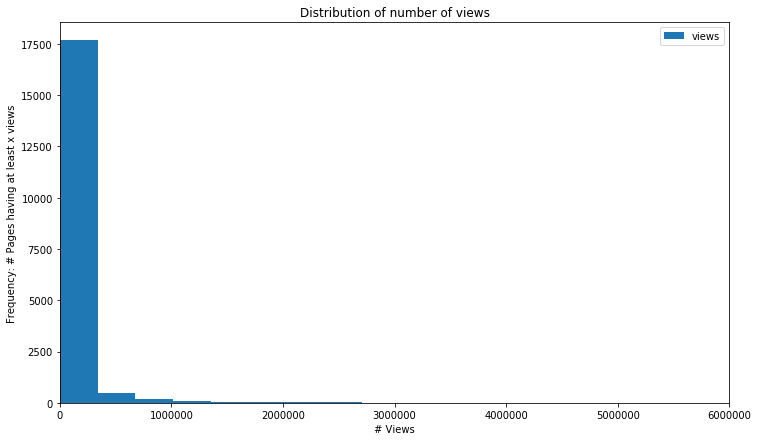

In [56]:
just_views_count = views_df.select('views').toPandas()
just_views_count.plot(kind="hist", bins=100, 
                     figsize=(12,7), title="Distribution of number of views")
plt.xlabel('# Views')
plt.ylabel('Frequency: # Pages having at least x views')
plt.xlim(0.0e7,0.6e7)
plt.show()

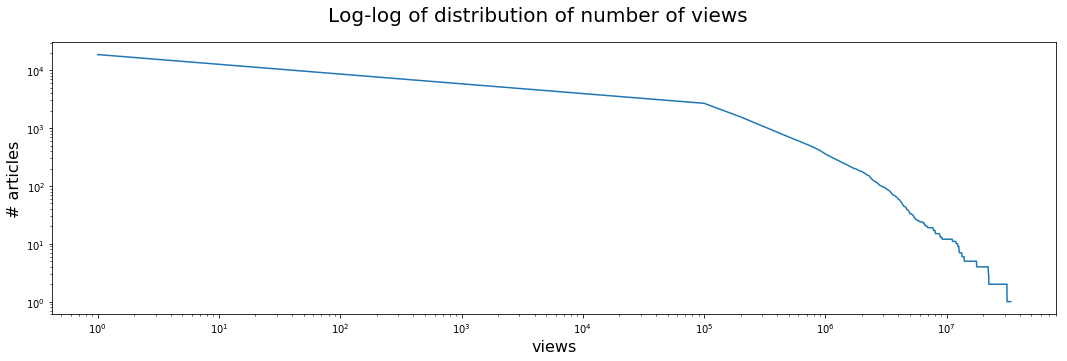

In [57]:
step = 100000;
xs = pd.Series(range(1,int(just_views_count.max()),step));
gratherThanData = xs.apply(lambda x: (just_views_count.views[just_views_count.views>=x]).count());

f, (ax2) = plt.subplots(1, 1);
plt.sca(ax2);
plt.plot(xs,gratherThanData);
plt.xlabel('views',fontsize=16);
plt.ylabel('# articles',fontsize=16);
plt.yscale('log'); plt.xscale('log');
f.set_size_inches(18, 5)
f.suptitle('Log-log of distribution of number of views',fontsize=20)
plt.show();

As seen we plotted our cumulative distribution in normal axes and in log-log axes. The distribution of the number of views follows a power law. Since it follows a power law, reporting mean or variance for a power-law-distributed data is not relevant as these statistics are not robust as they are sensitive to data. Instead, we use robust statistics and report the median and quartiles using boxplots. We compare boxplots with and without outliers.

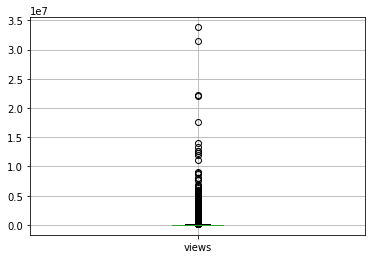

In [58]:
# with all data
just_views_count.boxplot();

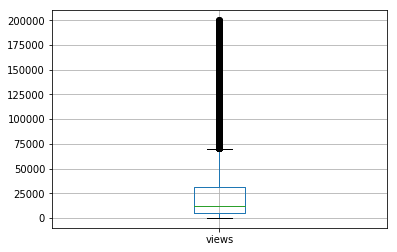

In [59]:
# without outliers
just_views_count[just_views_count['views'] < 200000].boxplot();

# Popularity metric 3

### Get number of external links per page


# Popularity metric 4

### Get length of article 
We assume that the longer the article, the more popular it may be.

In [62]:
# Loading the data
WIKIPEDIA_LENGTH_PARQUET = DATA_DIR + "wikipedia_no_outliers.parquet"

# loading the saved parquet files
articles = spark.read.parquet(WIKIPEDIA_LENGTH_PARQUET)
articles_length = articles.withColumn('article_lenght', F.length(articles.revision.text._VALUE))
articles_length_filter = articles_length.select("id","title","categories","article_lenght")
articles_length_filter.sort('article_lenght', ascending=False).show(5)

+--------+--------------------+--------------------+--------------+
|      id|               title|          categories|article_lenght|
+--------+--------------------+--------------------+--------------+
|52019122|Battle of Mosul (...|   military conflict|        636363|
|46230181|Saudi Arabian-led...|   military conflict|        434819|
|42563745|      War in Donbass|   military conflict|        393174|
| 6750583| History of Xinjiang|military conflict...|        364205|
| 3030955|    Kashmir conflict|   military conflict|        364091|
+--------+--------------------+--------------------+--------------+
only showing top 5 rows



**Distribution of article length** We bin the article length to get the number of pages having at least x article lengths. This is observed with a histogram plot.

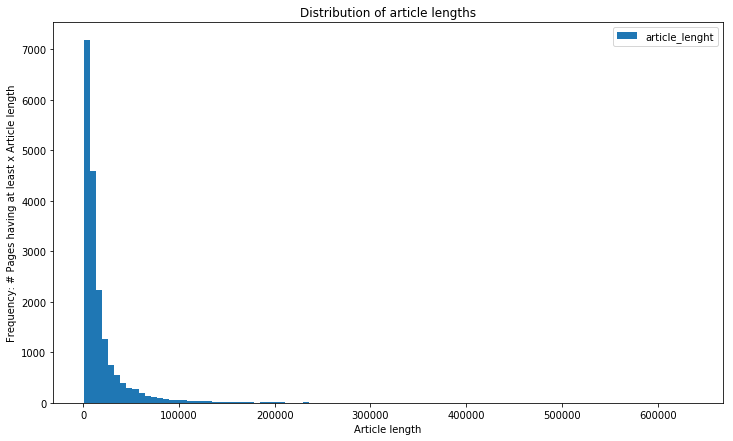

In [63]:
just_article_length = articles_length_filter.select('article_lenght').toPandas()
just_article_length.plot(kind="hist", bins=100, 
                     figsize=(12,7), title="Distribution of article lengths")
plt.xlabel('Article length')
plt.ylabel('Frequency: # Pages having at least x Article length')
plt.show()

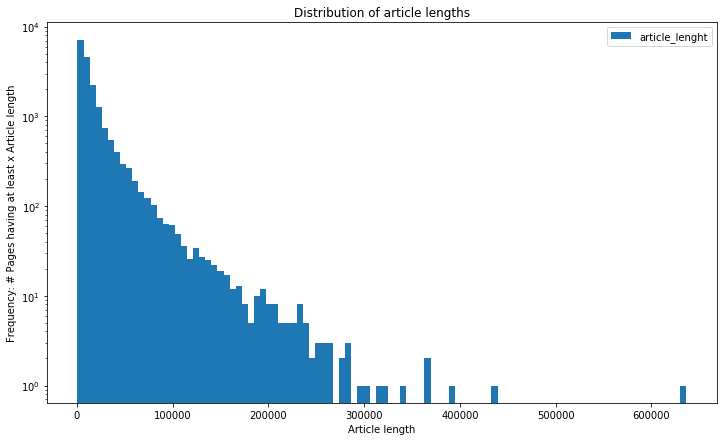

In [64]:
just_article_length = articles_length_filter.select('article_lenght').toPandas()
just_article_length.plot(kind="hist", bins=100, log = True,
                     figsize=(12,7), title="Distribution of article lengths")
plt.xlabel('Article length')
plt.ylabel('Frequency: # Pages having at least x Article length')
plt.show()

The distribution has a heavy-tailed distribution: it may follow a power law.

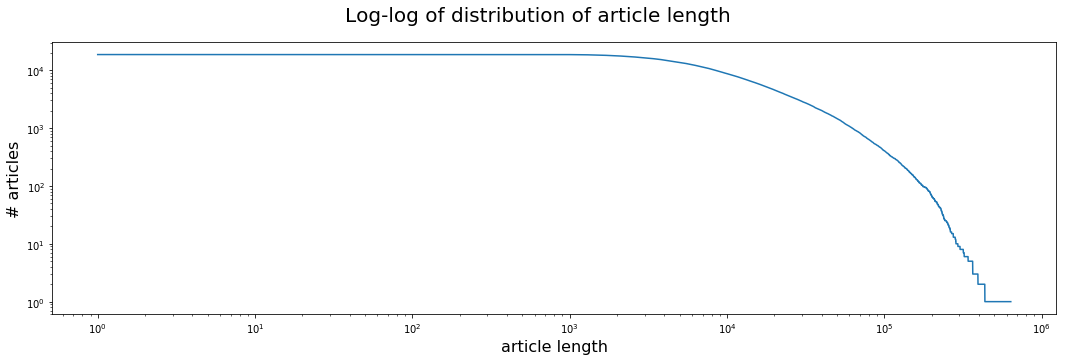

In [65]:
step = 100;
xs = pd.Series(range(1,int(just_article_length.max()),step));
gratherThanData = xs.apply(lambda x: (just_article_length.article_lenght[just_article_length.article_lenght>=x]).count());

f, (ax2) = plt.subplots(1, 1);
plt.sca(ax2);
plt.plot(xs,gratherThanData);
plt.xlabel('article length',fontsize=16);
plt.ylabel('# articles',fontsize=16);
plt.yscale('log'); plt.xscale('log');
f.set_size_inches(18, 5)
f.suptitle('Log-log of distribution of article length',fontsize=20)
plt.show();

---

# Joining tables on the page id

Having defined popularity metrics and importance criterion, we now join the tables on the page ID.

## 1. Join all popularity tables on page id

In [66]:
# need tables reference_count_page & articles_length_filter
references_popularity = reference_count_page.registerTempTable('references_popularity')
length_popularity = articles_length_filter.registerTempTable('length_popularity')
views_popularity = views_df.registerTempTable('views_popularity')

query_join_ref_length = """
select length_popularity.id, length_popularity.title, length_popularity.categories, length_popularity.article_lenght, references_popularity.refs_count
from length_popularity
join references_popularity
on length_popularity.id = references_popularity.id
"""

join_ref_length = spark.sql(query_join_ref_length)
join_ref_length.show(5)

+------+--------------------+--------------------+--------------+----------+
|    id|               title|          categories|article_lenght|refs_count|
+------+--------------------+--------------------+--------------+----------+
|  4823|         Balkan Wars|   military conflict|         56312|         8|
| 47928|   Battle of Naissus|   military conflict|         12440|        23|
| 50157|Battle of Stoke F...|   military conflict|         16061|        12|
|381602|    Baby Face Nelson|criminal, civilia...|         39762|        57|
|424102|Battle of Beachy ...|   military conflict|         21589|        26|
+------+--------------------+--------------------+--------------+----------+
only showing top 5 rows



In [67]:
# mini-test
join_ref_length.filter("title = 'Jahriyya revolt'").collect()

[Row(id=57214505, title='Jahriyya revolt', categories='military conflict', article_lenght=10027, refs_count=22)]

In [68]:
join_ref_length_sql = join_ref_length.registerTempTable('join_ref_length_sql')
query_join_popularity = """
select join_ref_length_sql.id, join_ref_length_sql.title, join_ref_length_sql.categories, join_ref_length_sql.article_lenght, views_popularity.views, join_ref_length_sql.refs_count  
from join_ref_length_sql
join views_popularity
on join_ref_length_sql.title = views_popularity.title
"""
popularity = spark.sql(query_join_popularity)
popularity.show(5)

+------+--------------------+--------------------+--------------+-------+----------+
|    id|               title|          categories|article_lenght|  views|refs_count|
+------+--------------------+--------------------+--------------+-------+----------+
|  4823|         Balkan Wars|   military conflict|         56312|1124826|         8|
| 47928|   Battle of Naissus|   military conflict|         12440|  56441|        23|
| 50157|Battle of Stoke F...|   military conflict|         16061| 113136|        12|
|381602|    Baby Face Nelson|criminal, civilia...|         39762|1927516|        57|
|424102|Battle of Beachy ...|   military conflict|         21589|  66081|        26|
+------+--------------------+--------------------+--------------+-------+----------+
only showing top 5 rows



## 2. Join each category table with popularity table

In [71]:
# need tables popularity, wiki_civil_conflict_df, wiki_civilian_attack_df, wiki_military_conflict_df
civil_conflict_df1 = spark.read.parquet(DATA_DIR + "wiki_civil_conflict_df.parquet")
military_conflict_df1 = spark.read.parquet(DATA_DIR + "wiki_military_conflict_df.parquet")
civilian_attack_df1 = spark.read.parquet(DATA_DIR + "wiki_civilian_attack_df.parquet")

popularity_sql = popularity.registerTempTable('popularity_sql')
civil_conflict = civil_conflict_df1.registerTempTable('civil_conflict')
military_conflict = military_conflict_df1.registerTempTable('military_conflict')
civilian_attack = civilian_attack_df1.registerTempTable('civilian_attack')

**Join between popularity & `civil conflict`**

In [72]:
query_join_popularity_civil_conflict = """
select popularity_sql.id, popularity_sql.title, popularity_sql.categories, popularity_sql.article_lenght, popularity_sql.views, popularity_sql.refs_count, civil_conflict.death, civil_conflict.end_date, civil_conflict.location
from popularity_sql, civil_conflict
where popularity_sql.id = civil_conflict.id
"""

popularity_civil_conflict = spark.sql(query_join_popularity_civil_conflict)
popularity_civil_conflict.show(5)

+--------+--------------------+--------------+--------------+------+----------+--------------------+--------------------+--------------------+
|      id|               title|    categories|article_lenght| views|refs_count|               death|            end_date|            location|
+--------+--------------------+--------------+--------------+------+----------+--------------------+--------------------+--------------------+
|25827443|Long, hot summer ...|civil conflict|          4473| 28498|         4|                null|      Summer of 1967|   [[United States]]|
|34516509|2000 UEFA Cup Fin...|civil conflict|         26461| 73384|        51|                null|         17 May 2000|City Hall Square,...|
|36647928|Baltimore municip...|civil conflict|         39343|  6461|        49|'''Deaths''': <br...|+1974-07-14T00:00...|[[Baltimore, Mary...|
|49364124|Şırnak clashes (2...|civil conflict|         13430|  2701|        27|                null|August 2015-May 2016|[[Şırnak]], [[Tur...|

In [73]:
# saving binary file
popularity_civil_conflict.write.mode('overwrite').parquet(DATA_DIR+"popularity_civil_conflict.parquet");

**Join between popularity & `military conflict`**

In [74]:
query_join_popularity_military_conflict = """
select popularity_sql.id, popularity_sql.title, popularity_sql.categories, popularity_sql.article_lenght, popularity_sql.views, popularity_sql.refs_count, military_conflict.death, military_conflict.end_date, military_conflict.location
from popularity_sql, military_conflict
where popularity_sql.id = military_conflict.id
"""

popularity_military_conflict = spark.sql(query_join_popularity_military_conflict)
popularity_military_conflict.show(5)

+------+--------------------+-----------------+--------------+-------+----------+--------------------+--------------------+--------------------+
|    id|               title|       categories|article_lenght|  views|refs_count|               death|            end_date|            location|
+------+--------------------+-----------------+--------------+-------+----------+--------------------+--------------------+--------------------+
|  4823|         Balkan Wars|military conflict|         56312|1124826|         8|                null|+1913-07-18T00:00...|{{hlist |[[Adrian...|
| 47928|   Battle of Naissus|military conflict|         12440|  56441|        23|             unknown|          268 or 269|       Niš (Q129259)|
| 50157|Battle of Stoke F...|military conflict|         16061| 113136|        12|Unknown, estimate...|        16 June 1487|East Stoke, Notti...|
|424102|Battle of Beachy ...|military conflict|         21589|  66081|        26|       No ships lost|        10 July 1690|English

In [75]:
#check if join works
#popularity_military_conflict.select("title like '%World War II%'")
popularity_military_conflict.filter("title = 'World War II'").collect()

[Row(id=32927, title='World War II', categories='military conflict', article_lenght=223212, views=33835972, refs_count=238, death='+73000000', end_date='+1945-09-02T00:00:00Z', location='[Russia (Q159), Europe (Q46), Africa (Q15), Pacific Ocean (Q98), Mediterranean Sea (Q4918), Asia (Q48), Atlantic Ocean (Q97), Middle East (Q7204), Southeast Asia (Q11708), Scandinavia (Q21195)]')]

In [76]:
# saving binary file
popularity_military_conflict.write.mode('overwrite').parquet(DATA_DIR+"popularity_military_conflict.parquet");

**Join between popularity & `civilian attack`**

In [77]:
query_join_popularity_civilian_attack = """
select popularity_sql.id, popularity_sql.title, popularity_sql.categories, popularity_sql.article_lenght, popularity_sql.views, popularity_sql.refs_count, civilian_attack.death, civilian_attack.end_date, civilian_attack.location
from popularity_sql, civilian_attack
where popularity_sql.id = civilian_attack.id
"""

popularity_civilian_attack = spark.sql(query_join_popularity_civilian_attack)
popularity_civilian_attack.show(5)

+--------+--------------------+--------------------+--------------+-------+----------+--------------------+--------------------+--------------------+
|      id|               title|          categories|article_lenght|  views|refs_count|               death|            end_date|            location|
+--------+--------------------+--------------------+--------------+-------+----------+--------------------+--------------------+--------------------+
|  381602|    Baby Face Nelson|criminal, civilia...|         39762|1927516|        57|                null|                null|                null|
|  464698|Massacres of Pole...|     civilian attack|        120291| 344457|       159|              +80000|+1944-00-00T00:00...|    Volhynia (Q7530)|
| 3177125|Springfield race ...|     civilian attack|        274021|  44412|       449|:16 (at least) 
*...|: August 14–16, 1908|: [[Springfield, ...|
| 9490463|  Mirusuvil massacre|     civilian attack|         11256|   4697|        17|              

In [78]:
# saving binary file
popularity_civilian_attack.write.mode('overwrite').parquet(DATA_DIR+"popularity_civilian_attack.parquet");

--- 
# Define a popularity score for each page


We use 4 features to define the popularity score of a page.

    We define the popularity score of an article as:

         SCORE = w1 * views + w2 * links + w3 * references + w4 * length 
        
        w1, w2, w3 and w4 are arbitrary weigths that normalize the features.

    We have noticed that the features references,length and views seem to follow a power law. Therefore, we use the 1/median to construct the weights associated to them.

### Civil conflict score 

In [8]:
popularity_civil_conflict_scoring = spark.read.parquet(DATA_DIR+"popularity_civil_conflict.parquet")

In [221]:
from pyspark.sql.types import IntegerType

def compute_weight(a_df, features_col):
    qnt_50 = []
    # for each col of the input features, cast into integer and compute median
    for col_ in features_col:
        a_df = a_df.withColumn(col_, a_df[col_].cast(IntegerType()))
        qnt_50.append(1/a_df.approxQuantile(col_, [0.5], 0.1)[0])
        
    weights = np.array(qnt_50)
    return weights, a_df


def compute_score(a_df, features_col):
    weights, a_df = compute_weight(a_df, features_col[1:])
    a_pd = a_df.toPandas()
    score = a_pd.iloc[:, 1] * weights[1] \
    + a_pd.iloc[:, 2] * weights[2]
    
    return score

In [216]:
popularity_civil_conflict_scoring.show(1)

+-------+-----------------+--------------+--------------+------+-----+--------------------+--------------------+
|     id|            title|    categories|article_lenght| views|death|            end_date|            location|
+-------+-----------------+--------------+--------------+------+-----+--------------------+--------------------+
|1690078|1967 Newark riots|civil conflict|         18540|225656|  +26|+1967-07-17T00:00...|[Jersey City (Q26...|
+-------+-----------------+--------------+--------------+------+-----+--------------------+--------------------+
only showing top 1 row



In [223]:
to_score = popularity_civil_conflict_scoring.select('id','views','article_lenght')

In [224]:
compute_weight(to_score, ['id','views','article_lenght'])

(array([2.61718649e-08, 5.65259171e-05, 6.54065014e-05]),
 DataFrame[id: int, views: int, article_lenght: int])

# Clustering approach

## Feature standardization

In [85]:
popularity_civil_conflict_scoring_ft = spark.read.parquet(DATA_DIR+"popularity_military_conflict.parquet")

In [86]:
popularity_civil_conflict_pd = popularity_civil_conflict_scoring_ft.toPandas()

In [87]:
popularity_civil_conflict_pd.head(10)

,id,title,categories,article_lenght,views,refs_count,death,end_date,location
0,189381,Hōgen rebellion,military conflict,11155,8124,9,None,+1156-08-16T00:00:00Z,Kyoto (Q34600)
1,252073,Sino-French War,military conflict,87709,264518,96,"2,100 killed or wounded",+1885-04-00T00:00:00Z,"Southeast [[mainland China]], [[Taiwan]], nort..."
2,423114,Operation Loyton,military conflict,10394,42453,13,Special Air Service 14 killed and another<br /...,+1944-10-09T00:00:00Z,Vosges Mountains (Q187843)
3,429190,Utah War,military conflict,85155,552444,63,38,+1858-07-00T00:00:00Z,Utah Territory (Q128026)
4,637353,Second Mithridatic War,military conflict,8448,40621,4,None,-0081-00-00T00:00:00Z,Anatolia (Q51614)
5,1014346,Eastern Front (World War I),military conflict,80069,1009239,66,"{{ubl|flagdeco|German Empire| '''1,468,811 – 2...",+1918-03-03T00:00:00Z,"[Central Europe (Q27509), Eastern Europe (Q274..."
6,1251276,Siege of Metz (1870),military conflict,8596,78299,3,"5,740 killed and wounded<br/>40,000 sick",+1870-10-27T00:00:00Z,Metz (Q22690)
7,1551938,Scotland in the Wars of the Three Kingdoms,military conflict,32308,120794,2,None,1644–51,Scotland (Q22)
8,1613922,Ogaden War,military conflict,34423,372460,54,"'''Ethiopia''':<br>6,133 killed <br>10,563 wou...",+1978-03-15T00:00:00Z,"[Ogaden (Q137555), Ethiopia (Q115)]"
9,2001345,Operation Charnwood,"military conflict, military operation",62338,71731,132,"{{ubl|3,817 casualties|ref| name=""Trew46""|Trew...",+1944-07-09T00:00:00Z,"Northern [[Caen]], [[Normandy]], France"


In [88]:
popularity_civil_conflict_pd.sort_values(by='views', ascending=False)

,id,title,categories,article_lenght,views,refs_count,death,end_date,location
2703,32927,World War II,military conflict,223212,33835972,238,+73000000,+1945-09-02T00:00:00Z,"[Russia (Q159), Europe (Q46), Africa (Q15), Pa..."
9594,4764461,World War I,military conflict,284173,31481685,254,+17000000,+1918-11-11T00:00:00Z,"[Europe (Q46), Australia and Oceania (Q55643),..."
218,32611,Vietnam War,military conflict,340373,22085710,536,{{Plainlist}} * {{flagdeco|North Vietnam}} {{f...,+1975-04-30T00:00:00Z,South Vietnam (Q180573)
521,863,American Civil War,military conflict,203619,17696187,212,"{{plainlist|\n*110,000+ killed in action/died ...",+1865-05-10T00:00:00Z,"[Southern United States (Q49042), Northern Uni..."
6285,11778948,Atomic bombings of Hiroshima and Nagasaki,military conflict,198440,13998970,143,"20 British, Dutch, and American [[prisoners of...","August 6 and August 9, 1945","[Hiroshima (Q34664), Nagasaki (Q38234)]"
13198,16772,Korean War,"military conflict, East Asian",262686,12674791,271,None,None,None
124,60098,Attack on Pearl Harbor,military conflict,107478,12641959,147,+2467,None,Pearl Harbor (Q127091)
9367,252854,Normandy landings,military conflict,85344,11984783,0,"10,000+ casualties; 4,414 confirmed dead {{efn...",6 June 1944,Normandy (Q15878)
11474,73246,Battle of Dunkirk,military conflict,40492,11172884,49,"* (Estimated)<br />61,774 total killed and wou...",+1940-06-04T00:00:00Z,Dunkirk (Q45797)
3832,771,American Revolutionary War,military conflict,238972,8794983,598,"'''United States:'''<br />\n<small>25,000–70,0...",+1783-09-03T00:00:00Z,"Eastern North America, [[Caribbean Sea]], [[In..."


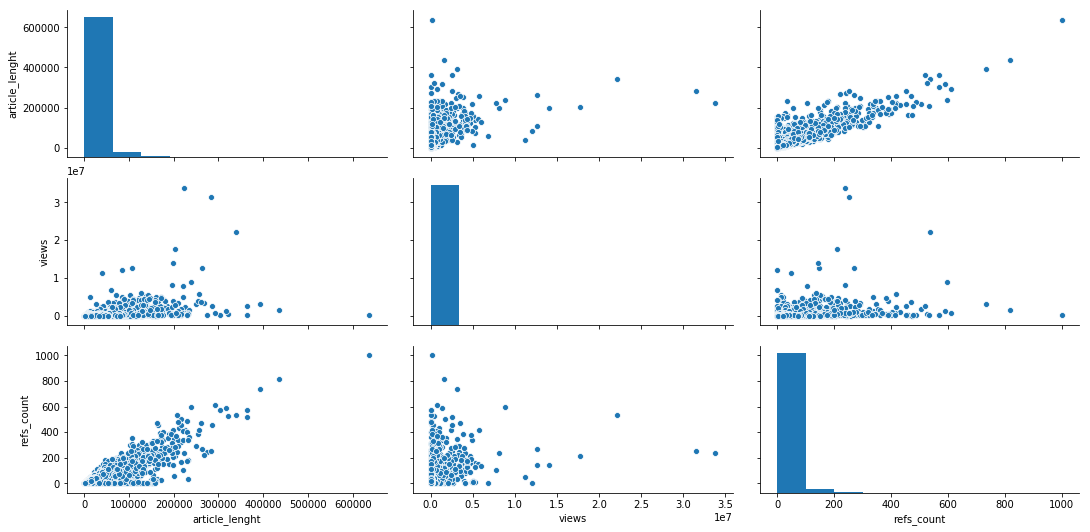

In [89]:
sns.pairplot(data=popularity_civil_conflict_pd, vars=['article_lenght', 'views', 'refs_count'], aspect=2);

In [28]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
popularity_civil_conflict_pd_minmax = min_max_scaler.fit_transform(popularity_civil_conflict_pd[['article_lenght', 'views']])

/Users/nasrine/miniconda3/envs/ada/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [29]:
popularity_civil_conflict_pd_minmax

array([[-0.86529297, -0.93121921],
       [-0.97579189, -0.99952246],
       [-0.46692042, -0.99408277],
       [-0.97110064, -0.99984285],
       [-0.69258602, -0.98332087],
       [-0.644906  , -0.99471776],
       [-0.86462726, -0.98371388],
       [-0.15273193, -0.9846891 ],
       [-0.82126257, -0.99887252],
       [-0.26306639, -0.99673381],
       [-0.83431035, -0.99934792],
       [-0.97041144, -0.99931008],
       [-0.77915879, -0.9889946 ],
       [-0.25917398, -0.99728092],
       [-0.91968485, -0.99814995],
       [-0.66475962, -0.97829372],
       [-0.94144943, -0.99540096],
       [-0.92694493, -0.99621538],
       [-0.81942992, -0.99748109],
       [-0.99024157, -0.99067957],
       [-0.79400789, -0.99141312],
       [ 1.        , -0.99296902],
       [-0.34629497, -0.98036683],
       [-0.72065521, -0.99271179],
       [-0.94516171, -0.99605915],
       [-0.77503143, -0.98292937],
       [-0.95420744, -0.99943794],
       [-0.65393607, -0.90888679],
       [-0.96637023,

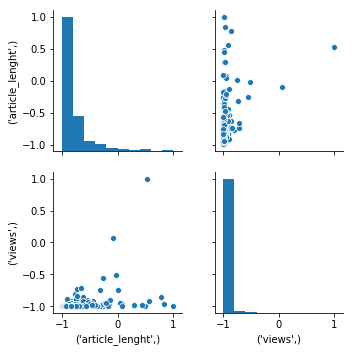

In [30]:
#popularity_civil_conflict_pd_minmax
sns.pairplot(pd.DataFrame(popularity_civil_conflict_pd_minmax, columns=[['article_lenght', 'views']]));

In [24]:
X_normalized = preprocessing.normalize(popularity_civil_conflict_pd[['article_lenght', 'views']], norm='l1')

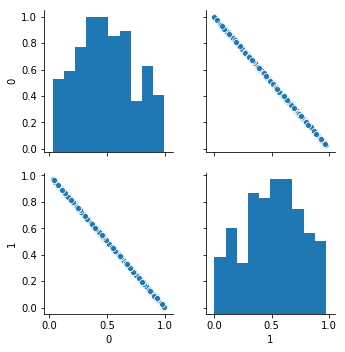

In [21]:
sns.pairplot(pd.DataFrame(X_normalized));

## Kmeans clustering

In [25]:
from sklearn.cluster import KMeans

#kmeans = KMeans(n_clusters=2, init='k-means++', random_state=0, n_jobs=-1).fit(popularity_civil_conflict_pd_minmax)
#popularity_civil_conflict_pd
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=0, n_jobs=-1).fit(
    X_normalized)
# fit_predict
kmeans.labels_

array([0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,

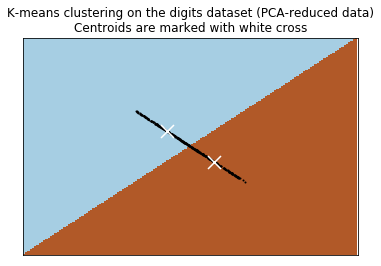

In [26]:
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].
reduced_data = X_normalized #popularity_civil_conflict_pd_minmax
# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset \n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()